In [10]:
# import torch
# from transformers import pipeline

# clip = pipeline(
#    task="zero-shot-image-classification",
#    model="openai/clip-vit-base-patch32",
#    dtype=torch.bfloat16,
#    device=0
# )
# labels = ["a photo of a cat", "a photo of a dog", "a photo of a car"]
# clip("http://images.cocodataset.org/val2017/000000039769.jpg", candidate_labels=labels)

In [11]:
# !uv pip install pillow
# !uv pip install matplotlib
# !uv pip install torchvision
!uv pip install faiss-cpu

Using Python 3.12.3 environment at: /home/hienlong/sources/Tourism-Chatbot/.venv
Resolved 3 packages in 333ms                                         
⠙ Preparing packages... (0/1)                                                   
⠙ Preparing packages... (0/1)-------------------     0 B/22.74 MiB           
⠙ Preparing packages... (0/1)------------------- 16.00 KiB/22.74 MiB         
⠙ Preparing packages... (0/1)------------------- 32.00 KiB/22.74 MiB         
⠙ Preparing packages... (0/1)------------------- 48.00 KiB/22.74 MiB         
⠙ Preparing packages... (0/1)------------------- 64.00 KiB/22.74 MiB         
⠙ Preparing packages... (0/1)------------------- 80.00 KiB/22.74 MiB         
⠙ Preparing packages... (0/1)------------------- 96.00 KiB/22.74 MiB         
⠙ Preparing packages... (0/1)------------------- 112.00 KiB/22.74 MiB        
⠙ Preparing packages... (0/1)------------------- 128.00 KiB/22.74 MiB        
⠙ Preparing packages... (0/1)------------------- 144.00 KiB/22.74 

In [12]:
import os
import torch
import faiss
import numpy as np
import torchvision.models as models
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms

In [13]:
print(f"Current working directory: {os.getcwd()}")

Current working directory: /home/hienlong/sources/Tourism-Chatbot/notebooks


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


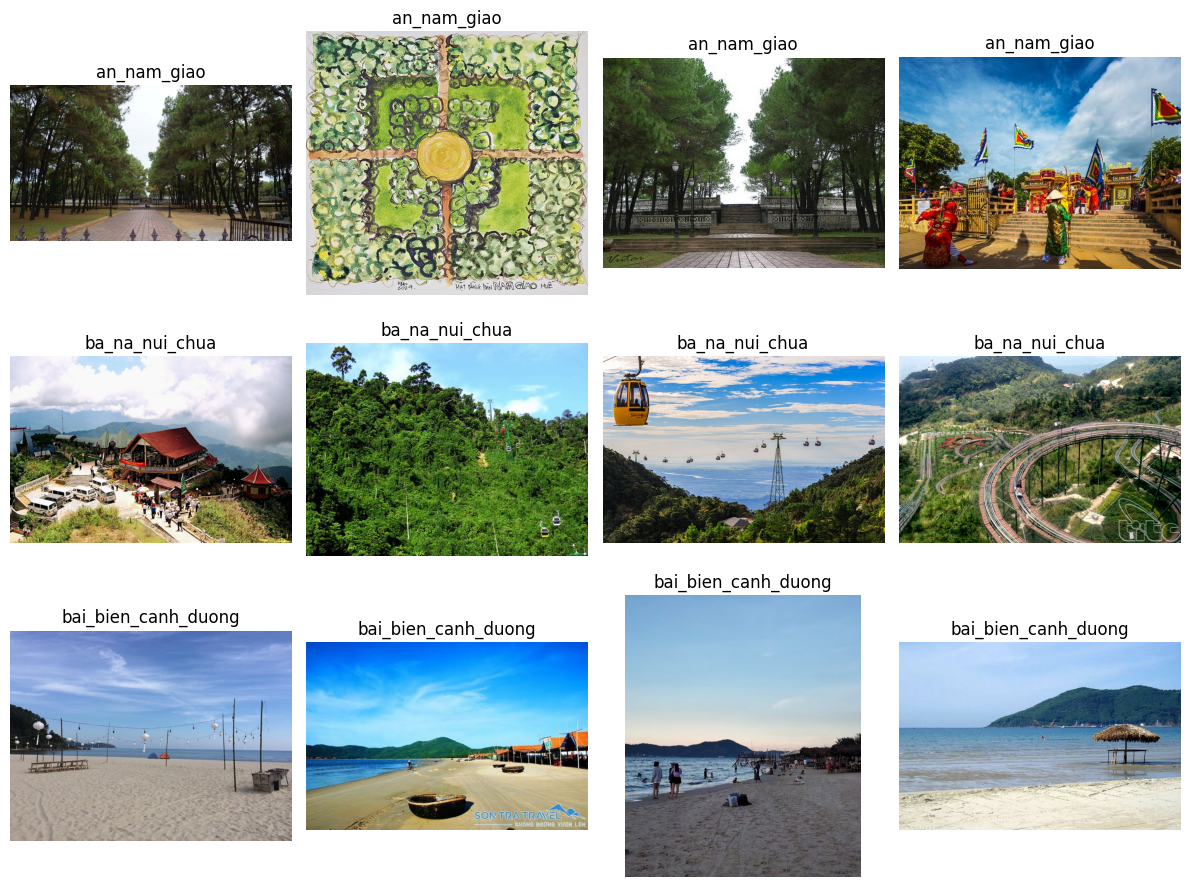

In [15]:
from PIL import Image

import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 4, figsize=(12, 9))
axes = axes.flatten()

root_dir = "../data/raw/crawled_images"
img_idx = 0

for folder_name in sorted(os.listdir(root_dir)):
    folder_path = os.path.join(root_dir, folder_name)
    if os.path.isdir(folder_path):
        for img_name in os.listdir(folder_path)[:4]:
            img_path = os.path.join(folder_path, img_name)
            if img_path.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                img = Image.open(img_path)
                if img_idx < len(axes):
                    axes[img_idx].imshow(img)
                    axes[img_idx].set_title(folder_name)
                    axes[img_idx].axis('off')
                    img_idx += 1

for i in range(img_idx, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [16]:
class ImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        self.class_names = []
        
        for label_idx, folder_name in enumerate(sorted(os.listdir(root_dir))):
            folder_path = os.path.join(root_dir, folder_name)
            if os.path.isdir(folder_path):
                self.class_names.append(folder_name)
                for img_name in os.listdir(folder_path):
                    img_path = os.path.join(folder_path, img_name)
                    if img_path.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                        self.images.append(img_path)
                        self.labels.append(label_idx)
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Update this path to match the one you chose above
dataset = ImageDataset("../data/raw/crawled_images", transform=transform)
print(f"Dataset size: {len(dataset)}")
print(f"Classes: {dataset.class_names}")

Dataset size: 3255
Classes: ['an_nam_giao', 'ba_na_nui_chua', 'bai_bien_canh_duong', 'bai_bien_cua_lo', 'bai_bien_cua_tung', 'bai_bien_hoang_hau', 'bai_bien_ky_co', 'bai_bien_lang_co', 'bai_bien_nam_o', 'bai_bien_o_son', 'bai_bien_sa_huynh', 'bai_bien_sam_son', 'bai_bien_thuan_an', 'ban_lac_mai_chau', 'bao_tang_chung_tich_chien_tranh', 'bao_tang_dieu_khac_champa', 'bao_tang_ho_chi_minh', 'bao_tang_my_thuat_cung_dinh_hue', 'bao_tang_my_thuat_tp_ho_chi_minh', 'bao_tang_phu_nu_nam_bo', 'bao_tang_phu_nu_viet_nam', 'ben_ninh_kieu', 'biet_thu_bao_dai', 'cang_ca_cho_ca_thuan_phuoc', 'cau_truong_tien', 'cho_dong_ba', 'cho_noi_cai_rang', 'chua_nam_nha', 'chua_ong', 'chua_quan_su', 'chua_tam_thai', 'chua_thien_mu', 'cong_vien_thien_duong_bao_son', 'cu_lao_cham', 'cung_an_dinh', 'cung_the_thao_tien_son', 'dao_ly_son', 'den_nghe', 'den_ngoc_son', 'deo_hai_van', 'di_tich_lich_su_son_my', 'dinh_binh_thuy', 'dinh_bo_ban', 'dinh_hang_kenh', 'dinh_nai_nam', 'dinh_tuy_loan', 'dong_thien_duong', 'du_lich

In [17]:
# Load a pre-trained model
weights = models.ResNet18_Weights.DEFAULT
model = models.resnet18(weights=weights)

# Remove the last layer (fc) to get the "embedding" (512 dimensions)
# This turns the model from a classifier into a feature extractor
model.fc = torch.nn.Identity()
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [18]:
# Extract embeddings from all images
dataloader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=2)

embeddings_list = []
image_paths = []

model = model.to(device)

with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(tqdm(dataloader, desc="Extracting embeddings")):
        images = images.to(device)
        embeddings = model(images)
        embeddings_list.append(embeddings.cpu().numpy())

# Concatenate all embeddings
all_embeddings = np.vstack(embeddings_list)
print(f"Extracted embeddings shape: {all_embeddings.shape}")
print(f"Total images: {len(dataset.images)}")

Extracting embeddings:   4%|▍         | 4/102 [00:06<02:35,  1.58s/it]/home/hienlong/sources/Tourism-Chatbot/.venv/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Extracting embeddings: 100%|██████████| 102/102 [02:13<00:00,  1.31s/it]

Extracted embeddings shape: (3255, 512)
Total images: 3255


In [19]:
# Normalize embeddings for cosine similarity
# L2 normalization makes inner product equivalent to cosine similarity
faiss.normalize_L2(all_embeddings)

print(f"Normalized embeddings shape: {all_embeddings.shape}")

Normalized embeddings shape: (3255, 512)


In [20]:
# Build FAISS index
dimension = all_embeddings.shape[1]  # 512 for ResNet18
print(f"Embedding dimension: {dimension}")

# Create index - using Inner Product (IP) since we normalized
# For cosine similarity, IP on normalized vectors = cosine similarity
index = faiss.IndexFlatIP(dimension)

# Add vectors to the index
index.add(all_embeddings.astype('float32'))

print(f"Index built with {index.ntotal} vectors")

Embedding dimension: 512
Index built with 3255 vectors


In [21]:
# Save the FAISS index
index_path = "../data/vector_db/faiss_tourism_images.index"
faiss.write_index(index, index_path)
print(f"Index saved to {index_path}")

# Save the metadata (image paths and labels)
import pickle
metadata = {
    'image_paths': dataset.images,
    'labels': dataset.labels,
    'class_names': dataset.class_names
}
metadata_path = "../data/vector_db/faiss_tourism_images_metadata.pkl"
with open(metadata_path, 'wb') as f:
    pickle.dump(metadata, f)
print(f"Metadata saved to {metadata_path}")

Index saved to ../data/vector_db/faiss_tourism_images.index
Metadata saved to ../data/vector_db/faiss_tourism_images_metadata.pkl


## Test Similarity Search

Let's test the index by searching for similar images.

In [22]:
# Function to search for similar images
def search_similar_images(query_idx, k=5):
    """
    Search for k most similar images to the query image.
    
    Args:
        query_idx: Index of the query image in the dataset
        k: Number of similar images to return
    """
    # Get the embedding for the query image
    query_embedding = all_embeddings[query_idx:query_idx+1].astype('float32')
    
    # Search the index
    distances, indices = index.search(query_embedding, k)
    
    return distances[0], indices[0]

# Test with a random image
test_idx = 100
distances, similar_indices = search_similar_images(test_idx, k=6)

print(f"Query image: {dataset.images[test_idx]}")
print(f"Class: {dataset.class_names[dataset.labels[test_idx]]}")
print("\nMost similar images:")
for i, (dist, idx) in enumerate(zip(distances, similar_indices)):
    print(f"{i+1}. Distance: {dist:.4f}, Image: {dataset.images[idx]}, Class: {dataset.class_names[dataset.labels[idx]]}")

Query image: ../data/raw/crawled_images/bai_bien_canh_duong/bai_bien_canh_duong_16.jpg
Class: bai_bien_canh_duong

Most similar images:
1. Distance: 1.0000, Image: ../data/raw/crawled_images/bai_bien_canh_duong/bai_bien_canh_duong_16.jpg, Class: bai_bien_canh_duong
2. Distance: 0.8157, Image: ../data/raw/crawled_images/bai_bien_canh_duong/bai_bien_canh_duong_43.jpg, Class: bai_bien_canh_duong
3. Distance: 0.8105, Image: ../data/raw/crawled_images/bai_bien_cua_tung/bai_bien_cua_tung_49.jpg, Class: bai_bien_cua_tung
4. Distance: 0.8105, Image: ../data/raw/crawled_images/bai_bien_lang_co/bai_bien_lang_co_43.jpg, Class: bai_bien_lang_co
5. Distance: 0.8036, Image: ../data/raw/crawled_images/bai_bien_cua_tung/bai_bien_cua_tung_21.jpg, Class: bai_bien_cua_tung
6. Distance: 0.8029, Image: ../data/raw/crawled_images/bai_bien_lang_co/bai_bien_lang_co_29.jpg, Class: bai_bien_lang_co


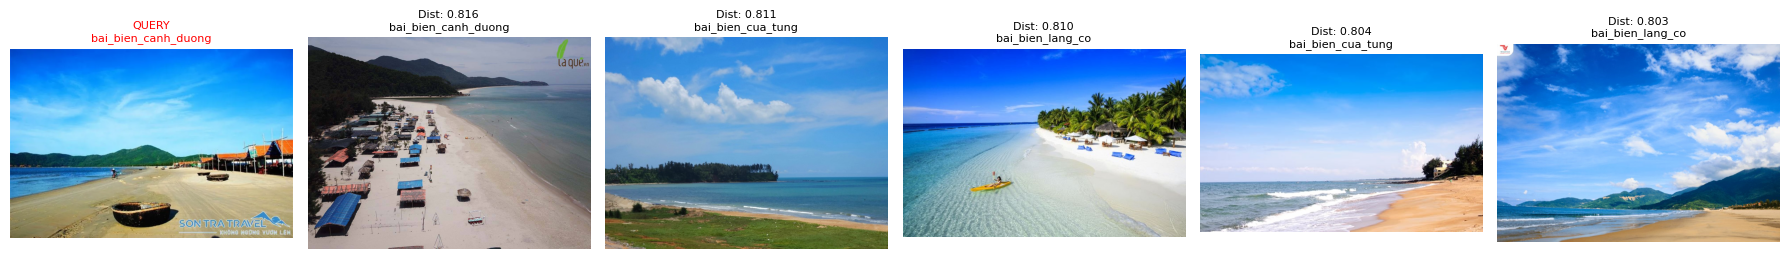

In [23]:
# Visualize the results
fig, axes = plt.subplots(1, 6, figsize=(18, 3))

for i, idx in enumerate(similar_indices):
    img = Image.open(dataset.images[idx])
    axes[i].imshow(img)
    axes[i].set_title(f"Dist: {distances[i]:.3f}\n{dataset.class_names[dataset.labels[idx]][:20]}", fontsize=8)
    axes[i].axis('off')
    if i == 0:
        axes[i].set_title(f"QUERY\n{dataset.class_names[dataset.labels[idx]][:20]}", fontsize=8, color='red')

plt.tight_layout()
plt.show()